In [1]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip

--2019-05-11 19:02:34--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.26.80.188, 2600:1409:12:285::e59, 2600:1409:12:282::e59
Connecting to download.microsoft.com (download.microsoft.com)|184.26.80.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   127MB/s    in 6.2s    

2019-05-11 19:02:40 (127 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



In [2]:
import os
import numpy as np
import shutil
import glob
import warnings
warnings.filterwarnings('ignore')

cat_files = os.listdir('PetImages/Cat')
dog_files = os.listdir('PetImages/Dog')

for cat in cat_files:
  src = os.path.join('PetImages/Cat',cat)
  dst = os.path.join('PetImages/Cat','cat_'+cat)
  os.rename( src,dst )

for dog in dog_files:
  src = os.path.join('PetImages/Dog',dog)
  dst = os.path.join('PetImages/Dog','dog_'+dog)
  os.rename( src , dst )
  

cat_files = glob.glob('PetImages/Cat/*')
dog_files = glob.glob('PetImages/Dog/*')

print(len(cat_files),len(dog_files))

cat_train = np.random.choice(cat_files, size=3000, replace=False)
dog_train = np.random.choice(dog_files, size=3000, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=1000, replace=False)
dog_val = np.random.choice(dog_files, size=1000, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=1000, replace=False)
dog_test = np.random.choice(dog_files, size=1000, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)
#rm -r PetImages/ kagglecatsanddogs_3367a.zip readme\[1\].txt MSR-LA\ -\ 3467.docx

12501 12501
Cat datasets: (3000,) (1000,) (1000,)
Dog datasets: (3000,) (1000,) (1000,)


### Splitting Train, Validation, Test Data

In [0]:
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)
#!rm -r test_data/ training_data/ validation_data/

In [4]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

IMG_DIM = (150,150)


train_files = glob.glob('training_data/*')
train_imgs = [];train_labels = []
for file in train_files:
  try:
    train_imgs.append( img_to_array(load_img( file,target_size=IMG_DIM )) )
    train_labels.append(file.split('/')[1].split('_')[0])
  except:
    pass
train_imgs = np.array(train_imgs)

validation_files = glob.glob('validation_data/*')
validation_imgs = [];validation_labels = []
for file in validation_files:
  try:
    validation_imgs.append( img_to_array(load_img( file,target_size=IMG_DIM )) )
    validation_labels.append(file.split('/')[1].split('_')[0])
  except:
    pass
train_imgs = np.array(train_imgs)
validation_imgs = np.array(validation_imgs)


print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Using TensorFlow backend.


Train dataset shape: (5999, 150, 150, 3) 	Validation dataset shape: (2000, 150, 150, 3)


In [0]:
# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

### Image Augmentation

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   zoom_range=0.3, 
                                   rotation_range=50,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

### Keras Model

In [7]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
from keras import optimizers

input_shape = (150, 150, 3)

input_l = Input((150,150,3))

l1_conv = Conv2D(16, kernel_size=(3, 3), activation='relu')(input_l)
l1_pool = MaxPooling2D(pool_size=(2, 2))(l1_conv)

l2_conv = Conv2D(64, kernel_size=(3, 3), activation='relu')(l1_pool)
l2_pool = MaxPooling2D(pool_size=(2, 2))(l2_conv)

l3_conv = Conv2D(128, kernel_size=(3, 3), activation='relu')(l2_pool)
l3_pool = MaxPooling2D(pool_size=(2, 2))(l3_conv)

l4 = Flatten()(l3_pool)
l4_dropout = Dropout(0.3)(l4)

l5 = Dense(512, activation='relu')(l4_dropout)
l5_dropout = Dropout(0.3)(l5)

output = Dense(1, activation='sigmoid')(l5_dropout)


model = Model(input_l, output)

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(), metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

In [8]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=2)       

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 17s - loss: 0.8622 - acc: 0.5310 - val_loss: 0.6788 - val_acc: 0.5240
Epoch 2/100
 - 13s - loss: 0.6918 - acc: 0.5479 - val_loss: 0.6593 - val_acc: 0.5730
Epoch 3/100
 - 13s - loss: 0.6772 - acc: 0.5933 - val_loss: 0.5895 - val_acc: 0.6900
Epoch 4/100
 - 13s - loss: 0.6583 - acc: 0.6218 - val_loss: 0.6041 - val_acc: 0.6760
Epoch 5/100
 - 13s - loss: 0.6430 - acc: 0.6293 - val_loss: 0.5745 - val_acc: 0.6990
Epoch 6/100
 - 13s - loss: 0.6190 - acc: 0.6515 - val_loss: 0.5982 - val_acc: 0.6750
Epoch 7/100
 - 14s - loss: 0.6172 - acc: 0.6640 - val_loss: 0.5325 - val_acc: 0.7120
Epoch 8/100
 - 13s - loss: 0.6209 - acc: 0.6582 - val_loss: 0.5567 - val_acc: 0.7320
Epoch 9/100
 - 13s - loss: 0.6211 - acc: 0.6560 - val_loss: 0.5010 - val_acc: 0.7410
Epoch 10/100
 - 13s - loss: 0.5903 - acc: 0.6806 - val_loss: 0.5094 - val_acc: 0.7390
Epoch 11/100
 - 13s - loss: 0.6082 - acc: 0.6700 - val_loss: 0.5429 - val_acc: 0.7120
Epoch 12/100
 -

### Model Performance

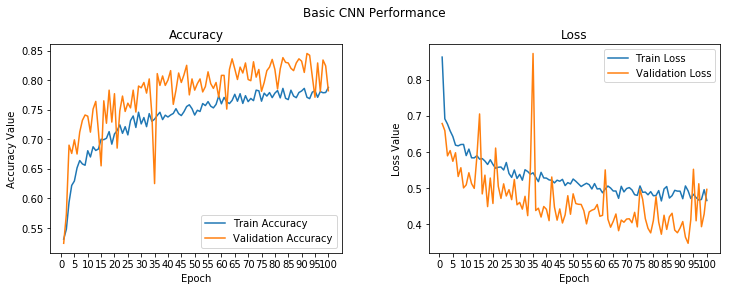

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
if not os.path.exists('saved_models'): os.mkdir('saved_models')
model.save('models/cnn scratch.h5')